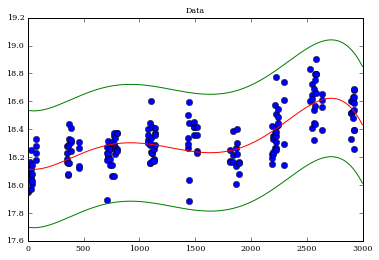

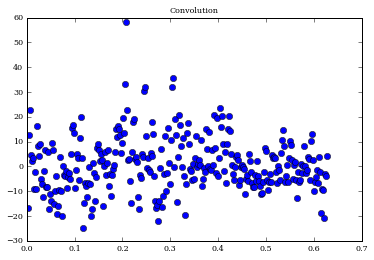

5.38440935625


/home/shepard/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:84: RuntimeWarning: invalid value encountered in divide


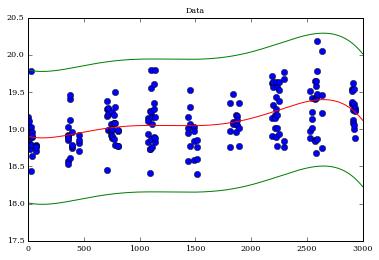

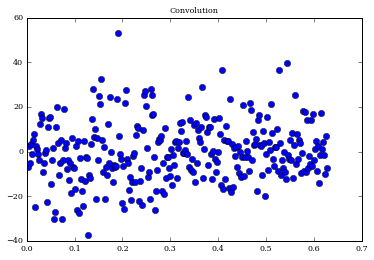

4.02325414366


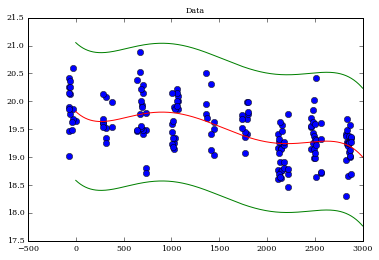

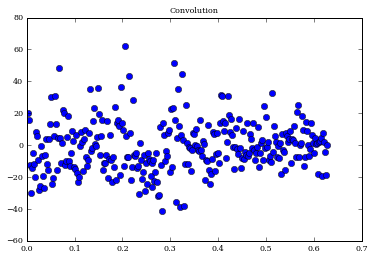

4.02277203312


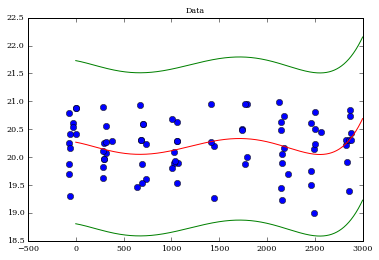

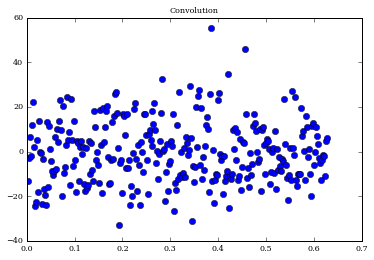

4.11144472718


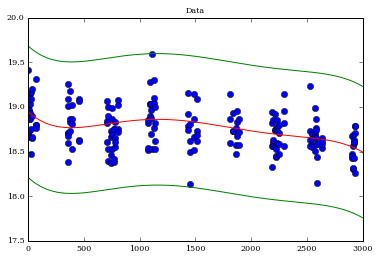

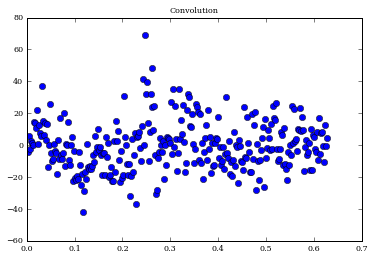

4.53943361354


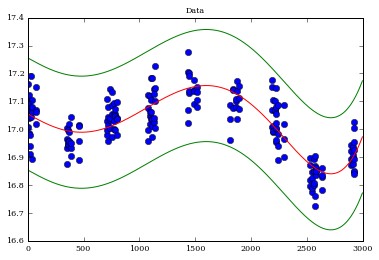

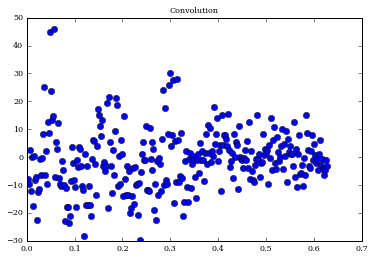

4.33959619415


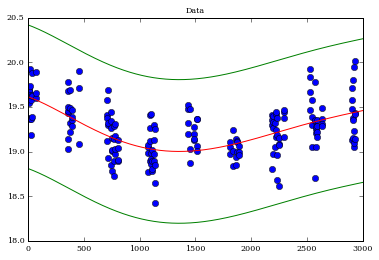

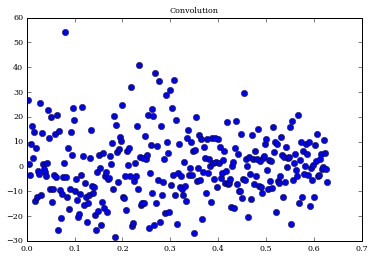

4.19825746036


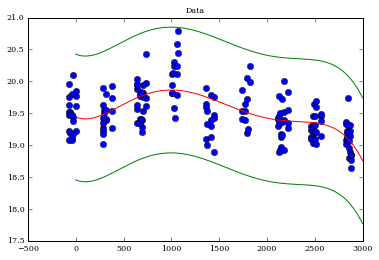

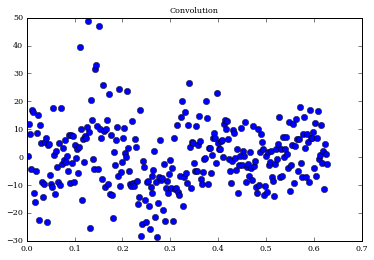

4.19509135856


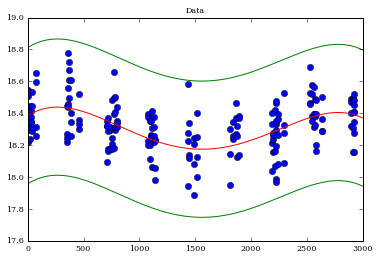

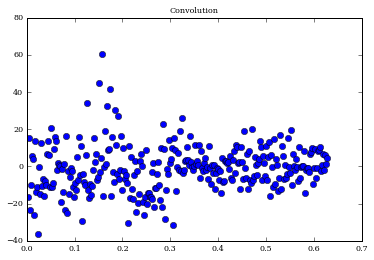

4.95743336963


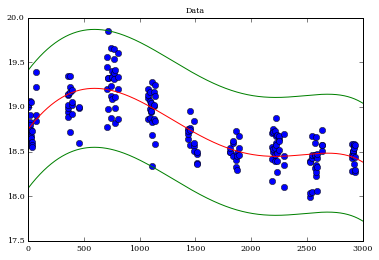

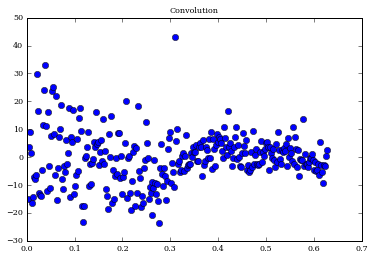

4.73179898761


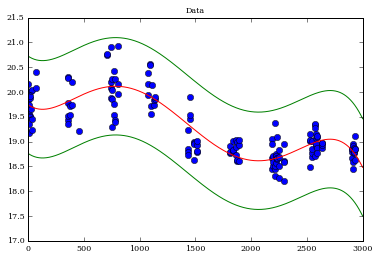

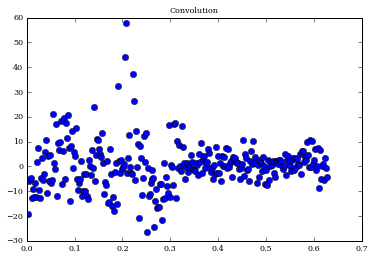

6.05807539902


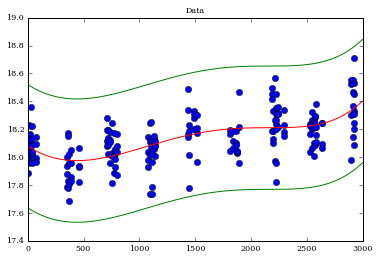

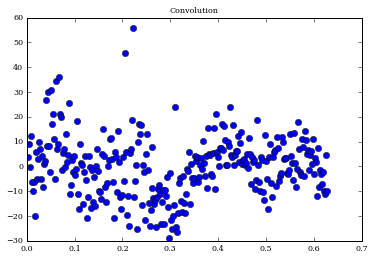

4.56535543608


In [4]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
import pyaov
from astropy.io import ascii

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)
import glob

glob = glob.glob('*/*.dat')
#print glob[:10]
#1001110074553.dat'
for k in glob:
    f = ascii.read(k)
    f0 = f[0][0]
    for i in range(len(f)):
        f[i][0] = f[i][0] - f0
    x = np.array(f['col1'])
    y = np.array(f['col2'])
    yerr = np.array(f['col3'])
    if x.size < 8 or y.size < 8:
        continue
    #generate data
    #x = np.linspace(0, 3000, num=200, endpoint=True)
    #y = np.cos(x*0.003)
    
    #calculate LS-periodogram
    period = np.array([i for i in range(10,3000,10)])
    omega = 2 * np.pi / period
    #yerr = np.array([np.random.random()/2 for i in y])
    omega1 = 2 * np.pi / 3000
    omega2 = 2 * np.pi / 10
    omega = np.linspace(omega1,omega2,num=301)

    PS = lomb_scargle(x, y, yerr, omega, generalized=True)
    
    p = np.poly1d(np.polyfit(x,y,5))
    xp = np.arange(0,3000,1)

    #sigma calculation
    S=y-p(x)
    sigma=0.0
    for i in range(len(y)):
        sigma+=S[i]**2
    sigma=sigma/len(y)
    sigma=np.sqrt(sigma)

    indicator=[]
    for i in range(len(y)):
        if 5*sigma < abs(y[i]-p(x[i])):
            indicator.append(i)
    y = np.delete(y,indicator)
    x = np.delete(x,indicator)
    yerr = np.delete(yerr,indicator)

    #aov calculation
    th,fr,frmax=pyaov.aovw(x,y,yerr,omega[-1],omega[0])

    #normalize periodgram
    PS = (PS - np.mean(PS))/np.std(PS)
    th = (th - np.mean(th))/np.std(th)

    #calculate peak
    conv = np.convolve(PS,th,mode='same')
    peak = conv.max()
    freq = conv.argmax()
    std = np.std(conv)
    u = np.median(conv)
    
    sig = (peak-u)/std
    
    if sig > 4:
        #plot data
        plt.figure(1)
        plt.title("Data")
        plt.plot(x, y, 'o',xp,p(xp),'r-',xp,p(xp)+5*sigma,'g-',xp,p(xp)-5*sigma,'g-')
        #plt.ylim((-2,2))

        #plot LS-periodogram
        '''plt.figure(2)
        plt.title("LS-periodogram")
        plt.plot(omega,PS,'go')

        #plot AOV periodogram
        plt.figure(3)
        plt.title("AOV periodogram")
        plt.plot(fr,th,'ro')
        # plt.xlim((0,3000))
        '''
        #plot convolution
        plt.figure(4)
        plt.title("Convolution")
        plt.plot(omega,conv,'bo')
        #pyaov.plper(frmax,x,y,fr,th)

        #plt.subplots_adjust(left=0,top=1,right=1,bottom=0)

        plt.show()

        print sig